In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import tempfile
import shutil
import tensorflow_datasets as tfds
import json
import glob

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

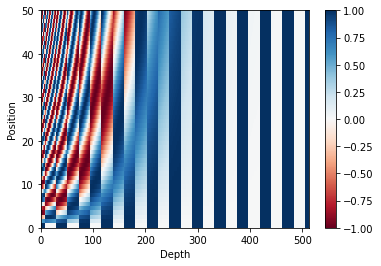

In [3]:
# 예시 벡터

sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [4]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [6]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [8]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [9]:
# 테스트
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)
tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 인코더

In [10]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [11]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더

In [12]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [13]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 데이터셋 받아오기
- AiHub 데이터셋: 훈련 데이터셋 중 TS_session2   
- ~~압축 해제 및 모든 하위 txt 파일 합쳐 저장하기~~
- ~~2번째 사용부터 그냥 파일자체를 명시하기~~
- json 형식 텍스트 처리를 위해 압축을 해제하고 각각 txt 파일에 대해 추출한 utterance 합치기
- 전처리 함수 적용

In [14]:
# 한글용 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [15]:
# 압축 해제 및 utterance 추출 함수

def extract_utterances(zip_file_path, MAX_SAMPLES=None):
    """
    압축 파일을 풀고 각 JSON 파일에서 utterance를 추출한 후
    질문(inputs)과 답변(outputs) 리스트로 구성합니다.
    
    Args:
        zip_file_path: 압축 파일 경로
        max_samples: 최대 샘플 수 (None이면 모든 샘플 사용)
        
    Returns:
        (inputs, outputs) 튜플 - 각각 질문과 답변 리스트
    """
    # 임시 디렉토리 생성
    temp_dir = tempfile.mkdtemp()
    all_utterances = []
    
    try:
        # 압축 파일 해제
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)
            print(f"압축 파일을 {temp_dir}에 해제했습니다.")
        
        # 모든 텍스트 파일 처리
        for root, dirs, files in os.walk(temp_dir):
            for filename in files:
                if filename.endswith('.txt'):
                    file_path = os.path.join(root, filename)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as file:
                            data = json.loads(file.read())
                        
                        # utterance 추출
                        file_utterances = []
                        for session_info in data.get('sessionInfo', []):
                            for dialog in session_info.get('dialog', []):
                                file_utterances.append(dialog.get('utterance', ''))
                        
                        all_utterances.extend(file_utterances)
                        print(f"{filename}에서 {len(file_utterances)}개의 발화문 추출")
                        
                    except Exception as e:
                        print(f"{file_path} 처리 중 오류 발생: {e}")
        
        # 질문과 답변으로 분리
        inputs, outputs = [], []
        for i in range(0, len(all_utterances)-1, 2):
            # 전처리 함수 적용
            inputs.append(preprocess_sentence(all_utterances[i]))
            outputs.append(preprocess_sentence(all_utterances[i + 1]))

            # 최대 샘플 수 제한
            if MAX_SAMPLES and len(inputs) >= MAX_SAMPLES:
                break
        
        print(f"총 {len(inputs)}개의 질문-답변 쌍을 생성했습니다.")
        return inputs, outputs
        
    finally:
        # 임시 디렉토리 삭제
        shutil.rmtree(temp_dir)
        print("임시 디렉토리를 삭제했습니다.")

In [17]:
zip_file_path = os.path.expanduser('~/aiffel/transformer_chatbot/data/TS_session2.zip')
MAX_SAMPLES = 50000
questions, answers = extract_utterances(zip_file_path, MAX_SAMPLES)

압축 파일을 /tmp/tmpfckrmyfw에 해제했습니다.
DAILY-087315-AP636265-WZ000005-02_01_01-S2.txt에서 32개의 발화문 추출
DAILY-164320-AP659347-WZ000004-02_03_06-S2.txt에서 32개의 발화문 추출
DAILY-197153-AP670164-WZ000007-02_04_09-S2.txt에서 32개의 발화문 추출
DAILY-126798-AP647786-WZ000001-01_05_03-S2.txt에서 32개의 발화문 추출
DAILY-092249-AP638205-WZ000005-01_03_01-S2.txt에서 32개의 발화문 추출
DAILY-165275-AP659721-WZ000006-01_03_10-S2.txt에서 32개의 발화문 추출
DAILY-206824-AP673034-WZ000003-01_01_01-S2.txt에서 32개의 발화문 추출
DAILY-166204-AP660119-WZ000005-01_06_02-S2.txt에서 32개의 발화문 추출
DAILY-021021-AP602339-WZ000011-01_01_03-S2.txt에서 28개의 발화문 추출
DAILY-150987-AP600581-WZ000011-02_04_03-S2.txt에서 32개의 발화문 추출
DAILY-045951-AP617846-WZ000008-02_04_01-S2.txt에서 28개의 발화문 추출
DAILY-049057-AP619570-WZ000001-02_03_10-S2.txt에서 28개의 발화문 추출
DAILY-151751-AP601325-WZ000001-01_03_10-S2.txt에서 32개의 발화문 추출
DAILY-186516-AP667106-WZ000005-01_06_02-S2.txt에서 32개의 발화문 추출
DAILY-098756-AP635633-WZ000001-01_05_03-S2.txt에서 32개의 발화문 추출
DAILY-242004-AP684805-WZ000006-01_04_10-S2.txt에서 32개

zip_file_path = os.path.expanduser('~/aiffel/transformer_chatbot/data/TS_session2.zip)' << 경로 오타나서 10분 헤맴(' 가 탈출함)

In [ ]:
# # 첫 사용시
# zip_file_path = '~/aiffel/transformer_chatbot/data/TS_session2.zip'  # 압축 파일 경로
# output_file_path = '~/aiffel/transformer_chatbot/data/TS_session2.txt'  # 결과 저장 파일 경로

# combined_text = extract_and_combine_txt_files(zip_file_path, output_file_path)
# print(f"총 {len(combined_text)} 글자의 텍스트를 추출함")

In [ ]:
# # 2회차 이후

# file_path = os.path.expanduser('~/aiffel/transformer_chatbot/data/TS_session2.txt')
# with open(file_path, 'r', encoding='utf-8') as file:
#     combined_text = file.read()
# print(f"총 {len(combined_text)} 글자의 텍스트를 불러옴")

### ~~전처리 함수 정의 및 적용~~

In [ ]:
# # 한글용 전처리 함수
# def preprocess_sentence(sentence):
#     sentence = sentence.lower().strip()
#     sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
#     sentence = re.sub(r'[" "]+', " ", sentence)
#     sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
#     sentence = sentence.strip()
#     return sentence

In [ ]:
# # 데이터셋 로드 및 전처리
# # preprocess bool값으로 설정
# questions = q_column.tolist()
# answers = a_column.tolist()
# preprocess = True

# if preprocess:
#     questions = [preprocess_sentence(q) for q in questions]
#     answers = [preprocess_sentence(a) for a in answers]

In [18]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 50000
전체 샘플 수 : 50000


In [19]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 알면 알 수록 영국은 정말 많은 곳을 식민화했네요 .
전처리 후의 22번째 답변 샘플: 그렇죠 . 한국도 같은 경험을 가졌으니까 동플로리다와 교감을 나누기가 좀 더 수월하겠죠 .


### SubwordTextEncoder 사용

In [20]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print('완료')

완료


In [21]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [22]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8225]
END_TOKEN의 번호 : [8226]


In [23]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8227


### 각 단어를 고유 정수로 인코딩 및 패딩

In [24]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [7139, 374, 5403, 2545, 14, 18, 45, 1237, 7013, 220, 5081, 2]
정수 인코딩 후의 21번째 답변 샘플: [1040, 1, 570, 27, 284, 476, 91, 1391, 6189, 1017, 155, 5534, 38, 290, 1797, 3623, 2646, 81, 16, 119, 610, 7356, 98, 2]


In [25]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [26]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [27]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8227
필터링 후의 질문 샘플 개수: 37151
필터링 후의 답변 샘플 개수: 37151


In [28]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 정의 및 학습

In [29]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [30]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3160320     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [31]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

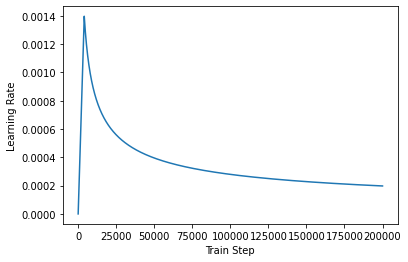

In [33]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [34]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [35]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
581/581 [==============================] - 42s 57ms/step - loss: 3.6680 - accuracy: 0.0394
Epoch 2/10
581/581 [==============================] - 33s 57ms/step - loss: 2.7164 - accuracy: 0.1047
Epoch 3/10
581/581 [==============================] - 33s 57ms/step - loss: 2.1940 - accuracy: 0.1479
Epoch 4/10
581/581 [==============================] - 33s 57ms/step - loss: 1.9015 - accuracy: 0.1743
Epoch 5/10
581/581 [==============================] - 33s 57ms/step - loss: 1.7210 - accuracy: 0.1875
Epoch 6/10
581/581 [==============================] - 33s 57ms/step - loss: 1.5875 - accuracy: 0.1971
Epoch 7/10
581/581 [==============================] - 33s 57ms/step - loss: 1.4808 - accuracy: 0.2058
Epoch 8/10
581/581 [==============================] - 33s 57ms/step - loss: 1.3670 - accuracy: 0.2167
Epoch 9/10
581/581 [==============================] - 33s 57ms/step - loss: 1.2390 - accuracy: 0.2312
Epoch 10/10
581/581 [==============================] - 33s 57ms/step - loss: 1.123

### 테스트

In [36]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [37]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [38]:
sentence_generation('좋은 아침이야')

입력 : 좋은 아침이야
출력 : 네 정말 멋진데요 저도 행복해요


'네 정말 멋진데요 저도 행복해요'

In [39]:
sentence_generation("나 너무 졸려")

입력 : 나 너무 졸려
출력 : 네 안녕하세요 저는 이제 헬로 , 년 월 일 영화 보러 갈게


'네 안녕하세요 저는 이제 헬로 , 년 월 일 영화 보러 갈게'

In [40]:
sentence_generation("세피리아 할래?")

입력 : 세피리아 할래?
출력 : 리디아 고베크만 , 고베토벤 시리즈는 토너 아니고 , 내가 언제나 쉬운 시간이나 이제 저녁 먹으러 가야겠다


'리디아 고베크만 , 고베토벤 시리즈는 토너 아니고 , 내가 언제나 쉬운 시간이나 이제 저녁 먹으러 가야겠다'

In [41]:
sentence_generation("잠을 잘 못 잤어")

입력 : 잠을 잘 못 잤어
출력 : 시간만에 다시 오셨네요 . 잘 지내셨나요 ? !


'시간만에 다시 오셨네요 . 잘 지내셨나요 ? !'

In [42]:
sentence_generation("오키나와 여행은 어땠어?")

입력 : 오키나와 여행은 어땠어?
출력 : 오키아가리코보시는 건 어떨까요 ? 여샌은 년 월 일 레인 우편에서 방송된 일본의 텔레비전 드라마입니다 .


'오키아가리코보시는 건 어떨까요 ? 여샌은 년 월 일 레인 우편에서 방송된 일본의 텔레비전 드라마입니다 .'

In [44]:
sentence_generation("여행지 소개해줘")

입력 : 여행지 소개해줘
출력 : 라멘은 싱가포르 금융관리국입니다 .


'라멘은 싱가포르 금융관리국입니다 .'